# Current State

## Domain Background

- Canola life cycle: May (seeding), late June - early July (bolting, flowering), July (peak flowering), mid August - early September (swathing), September (harvest)

- minimum growth temp.: -5 degrees celsius (~268 degrees Kelvin)

## Hypothesis Propositions

In [1]:
# I. High temperatures (low precipitation) have a negative impact on Canola yield in Saskatchewan.
## avg. temp in growing season, cum. heat days, heatwaves (X consecutive days above threshold), heat stress index

# II. Greater-than-average precipitation has a positive impact on Canola yield in Saskatchewan.
## heavy tp frequency

# III. Cooler-than-average nocturnal temperatures have a positive impact on Canola yield in Saskatchewan.
## avg nocturnal temperature

# IV. The beginning of July, i.e. the early flowering period, is the critical time period for the effects in (I).

# V. The critical threshold for temperature-caused yield loss is 30 degrees celsius.

# VI. Increased precipitation may offset the negative impact of high temperatures on floweing canola.

# VII. Canola crop yield increases (decreases) with increasing average temperatures in June and August (in July).

# VIII. The crucial time for high precipitation benefits is the month of July, i.e. peak flowering season.

## Preparation

### Libraries

In [2]:
import pandas as pd
import numpy as np

import glob
import xarray as xr

import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing 

from sklearn.linear_model import LinearRegression

from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.utils.plotting import plot_series

import seaborn as sns

## Data Preparations 

### Canola yield

In [3]:
#read dataframe 
canola_2 = df = pd.read_csv('../data/rm-yields-data.csv', header=0, index_col=0, parse_dates=True)
canola_small = canola_2.iloc[:, [0, 2]].copy()

#cut of first 33 observations (NAs)
canola_small.drop(canola_small.index[:33], inplace=True)

#filter out every observation that contains NAs
canola_filtered = canola_small.groupby('RM').filter(lambda group: not group['Canola'].isnull().any())

# how may districts? 148
num_districts = canola_filtered.groupby('RM').ngroups

#extract only the first district 
canola_dist1 = canola_filtered[canola_filtered['RM'] == 1]

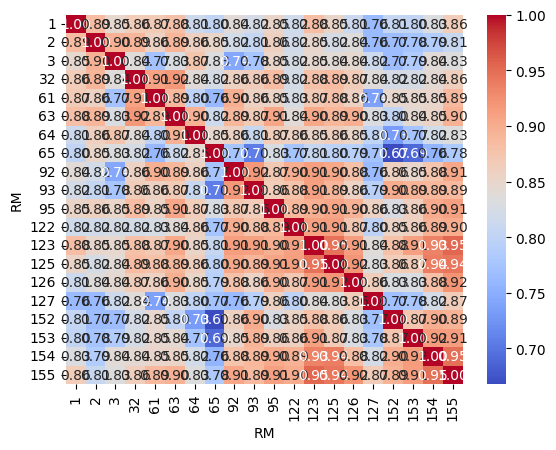

In [4]:
#print(canola_filtered)

df_reset = canola_filtered.reset_index()
#print(df_reset)
# Pivot the DataFrame
pivot_df = df_reset.pivot(index='Year', columns='RM', values='Canola')

#print(pivot_df)
# Calculate correlation matrix
correlation_matrix = pivot_df.corr()
correlation_matrix
# Display or use the correlation matrix
#print(correlation_matrix)

selected_columns = pivot_df.columns[:20]  
correlation_matrix_subset = pivot_df[selected_columns].corr()
sns.heatmap(correlation_matrix_subset, cmap='coolwarm', annot=True, fmt=".2f")
plt.show()


In [5]:
# Group by 'RM' and check if 'Canola' has any missing values in each group
districts_with_full_data = canola_filtered.groupby('RM')['Canola'].apply(lambda group: not group.isnull().any())

# Extract the list of districts with full data
districts_with_full_data_list = districts_with_full_data[districts_with_full_data].index.tolist()

# Print or use the list as needed
print("Districts with full data:", districts_with_full_data_list)
print(len(districts_with_full_data_list))

Districts with full data: [1, 2, 3, 32, 61, 63, 64, 65, 92, 93, 95, 122, 123, 125, 126, 127, 152, 153, 154, 155, 156, 157, 181, 183, 184, 185, 186, 211, 213, 214, 217, 221, 222, 241, 243, 244, 245, 246, 250, 251, 252, 254, 271, 273, 276, 277, 278, 280, 281, 283, 284, 304, 305, 307, 308, 309, 310, 312, 314, 315, 316, 331, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 349, 350, 351, 352, 366, 367, 368, 369, 370, 371, 372, 373, 377, 378, 380, 381, 382, 394, 395, 398, 399, 400, 401, 402, 403, 404, 405, 406, 408, 409, 410, 411, 426, 427, 428, 429, 430, 431, 435, 436, 437, 438, 439, 440, 442, 456, 457, 458, 459, 460, 461, 463, 464, 466, 467, 468, 471, 472, 486, 487, 488, 490, 491, 493, 494, 497, 499, 501, 502, 588, 622]
148


### Weather Data 

In [6]:
cop_all = xr.open_mfdataset(paths='../data/raw_data/*.nc', combine='by_coords')

In [7]:
# use mean of latitude, longitude dims as they only deviate marginally
cop_all.items

<bound method Mapping.items of <xarray.Dataset>
Dimensions:    (longitude: 4, latitude: 3, time: 267072)
Coordinates:
  * longitude  (longitude) float32 -101.6 -101.5 -101.4 -101.3
  * latitude   (latitude) float32 49.2 49.1 49.0
  * time       (time) datetime64[ns] 1971-04-01 ... 2022-10-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(5136, 3, 4), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(5136, 3, 4), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-11 10:41:08 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...>

In [8]:
cop_all_centralized = cop_all.mean(dim=['latitude', 'longitude'])

cop_all_centralized.items

<bound method Mapping.items of <xarray.Dataset>
Dimensions:  (time: 267072)
Coordinates:
  * time     (time) datetime64[ns] 1971-04-01 ... 2022-10-31T23:00:00
Data variables:
    t2m      (time) float32 dask.array<chunksize=(5136,), meta=np.ndarray>
    tp       (time) float32 dask.array<chunksize=(5136,), meta=np.ndarray>>

In [9]:
column_to_append = canola_dist1['Canola'].tolist()

dist1_df = cop_all_centralized.to_dataframe()

years = dist1_df.index.year
dist1_df['Canola'] = [column_to_append[year - 1971] for year in years]

dist1_df.tail()


,t2m,tp,Canola
time,,,
2022-10-31 19:00:00,285.548615,0.000000e+00,37.4
2022-10-31 20:00:00,286.406525,5.997717e-07,37.4
2022-10-31 21:00:00,286.554352,5.997717e-07,37.4
2022-10-31 22:00:00,286.267975,5.997717e-07,37.4
2022-10-31 23:00:00,285.108826,5.997717e-07,37.4


### Visualization

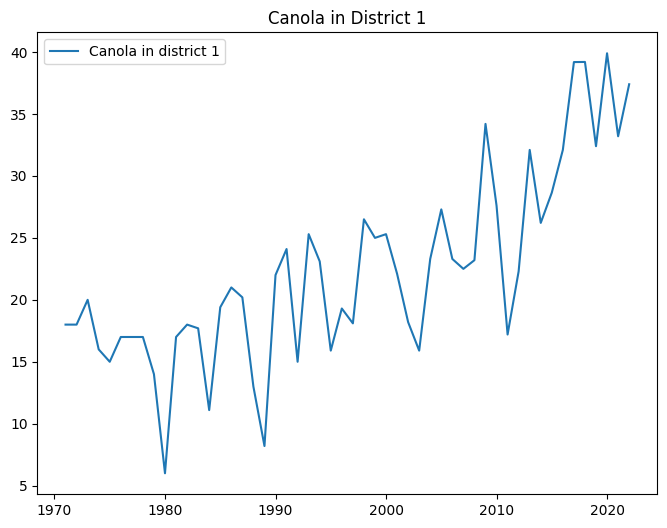

In [10]:
canola_dist1 = canola_filtered[canola_filtered['RM'] == 1]

plt.figure(figsize=(8, 6))
plt.plot(canola_dist1['Canola'], label=f'Canola in district 1')
plt.title('Canola in District 1')
plt.legend()
plt.show()

### Differencing 

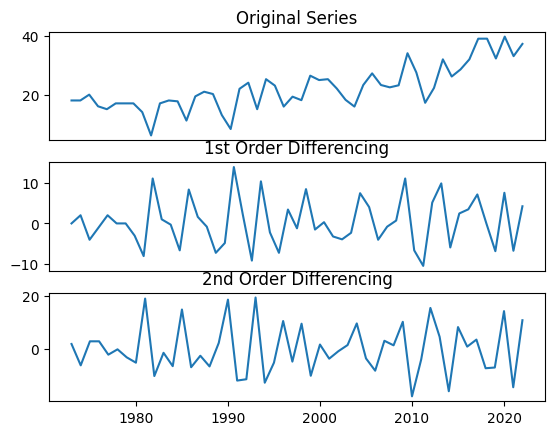

In [11]:
# Differencing Orders (confirms that d is likely 0)
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(canola_dist1.Canola); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(canola_dist1.Canola.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(canola_dist1.Canola.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

### Stationarity 

In [12]:
# Split into test and trainingsdata 

test_set = canola_dist1.iloc[-10:]
training_set = canola_dist1.iloc[:-10]

#check for stationarity with Augmented Dickey-Fuller (ADF) test 

#in the whole dataset
result = adfuller(canola_dist1['Canola'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

#in the trainingset
result = adfuller(training_set['Canola'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')



ADF Statistic: 1.54792837232326
p-value: 0.9976926349856662
ADF Statistic: -3.9704253489575065
p-value: 0.001573541015475178


### Detrending 

<YearEnd: month=12>
ADF Statistic: -6.5732905670938715
p-value: 7.838097223650518e-09


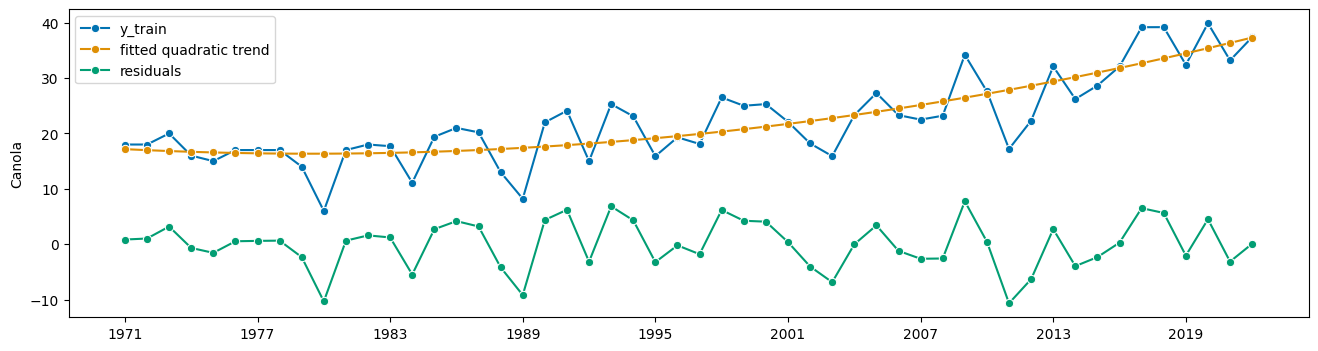

In [13]:
canola_dist1.index = canola_dist1.index.to_period('A')

#change frequency 
frequency = canola_dist1.index.freq

print(frequency)

# linear detrending
forecaster = PolynomialTrendForecaster(degree=2)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(canola_dist1['Canola'])


forecaster = PolynomialTrendForecaster(degree=2)
fh_ins = -np.arange(len(canola_dist1['Canola'])) 
y_pred = forecaster.fit(canola_dist1['Canola']).predict(fh=fh_ins)

plot_series(canola_dist1['Canola'], y_pred, yt, labels=["y_train", "fitted quadratic trend", "residuals"]);

residuals = yt

#ADF 
result = adfuller(residuals)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


In [14]:
# add detrended time series to dataframe 
canola_dist1.loc[:,'Canola_detrend'] = yt

C:\Users\HP\AppData\Local\Temp\ipykernel_8632\3567572310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canola_dist1.loc[:,'Canola_detrend'] = yt


In [15]:
dist1_df.head()

,t2m,tp,Canola
time,,,
1971-04-01 00:00:00,267.042023,0.010006,18.0
1971-04-01 01:00:00,266.616119,0.000009,18.0
1971-04-01 02:00:00,266.401428,0.000017,18.0
1971-04-01 03:00:00,266.300446,0.000024,18.0
1971-04-01 04:00:00,266.171661,0.000031,18.0


# Feature Extraction 

### Average Temperature

In [16]:
# get average temperature annual

dist1_df_annual = dist1_df.resample('A').mean()
dist1_df_annual.head()

column_to_append = dist1_df_annual['t2m'].tolist()
canola_dist1.loc[:,'average_temp_in_year'] = column_to_append

canola_dist1.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_8632\3013189039.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canola_dist1.loc[:,'average_temp_in_year'] = column_to_append


,RM,Canola,Canola_detrend,average_temp_in_year
1971,1,18.0,0.835685,285.822937
1972,1,18.0,1.019651,285.253143
1973,1,20.0,3.180447,286.780853
1974,1,16.0,-0.681926,285.641998
1975,1,15.0,-1.567468,285.024506


In [17]:
# average temperature in one month 

for month in range(4,11):
    
    dist1_df_month = dist1_df.resample('MS').mean()
    month_data = dist1_df_month[dist1_df_month.index.month == month]

    column_to_append = month_data['t2m'].tolist()
    canola_dist1.loc[:, f'average_temp_in_{month}'] = column_to_append

canola_dist1.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_8632\859018910.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canola_dist1.loc[:, f'average_temp_in_{month}'] = column_to_append
C:\Users\HP\AppData\Local\Temp\ipykernel_8632\859018910.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canola_dist1.loc[:, f'average_temp_in_{month}'] = column_to_append
C:\Users\HP\AppData\Local\Temp\ipykernel_8632\859018910.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

,RM,Canola,Canola_detrend,average_temp_in_year,average_temp_in_4,average_temp_in_5,average_temp_in_6,average_temp_in_7,average_temp_in_8,average_temp_in_9,average_temp_in_10
1971,1,18.0,0.835685,285.822937,276.701538,283.854309,289.748718,290.672729,293.979156,286.152252,279.494812
1972,1,18.0,1.019651,285.253143,275.824646,285.927246,290.569458,290.008667,292.916992,284.534332,276.834778
1973,1,20.0,3.180447,286.780853,277.133759,284.741882,290.786469,292.997559,294.354370,285.549774,281.680603
1974,1,16.0,-0.681926,285.641998,275.509277,281.658173,290.150146,295.285004,290.413635,284.899323,281.372925
1975,1,15.0,-1.567468,285.024506,272.058929,283.596344,289.199188,295.075470,290.203400,285.181213,279.578491


In [18]:
dist1_df.head()

,t2m,tp,Canola
time,,,
1971-04-01 00:00:00,267.042023,0.010006,18.0
1971-04-01 01:00:00,266.616119,0.000009,18.0
1971-04-01 02:00:00,266.401428,0.000017,18.0
1971-04-01 03:00:00,266.300446,0.000024,18.0
1971-04-01 04:00:00,266.171661,0.000031,18.0


### Number of hot days 

In [19]:
#hot days in one year 
dist1_df_hot = dist1_df 

# add extra columns containing the years and the months
dist1_df_hot['year'] = dist1_df_hot.index.year
dist1_df_hot['month'] = dist1_df_hot.index.month
dist1_df['day'] = dist1_df_hot.index.day

# get variables year, month and canola from old data frame 
daily_df = dist1_df.resample('D').first()
#print(len(daily_df))
daily_df = daily_df[["Canola","year","month"]]

# Resample the data to daily frequency and get the maximum temperature for each day
daily_max_temperature = dist1_df_hot['t2m'].resample('D').max()

# add max temp per day to data frame
daily_df['max_temp'] = daily_max_temperature
print(len(daily_df))
#print(daily_df[210:230])

# count hot days per year 
hot_days_by_year = daily_df[daily_df["max_temp"] > 303].groupby('year').size()

hot_days_by_year = hot_days_by_year.reindex(range(dist1_df_hot['year'].min(), dist1_df_hot['year'].max() + 1), fill_value=0)

#hot_days_by_year.plot()
#plt.show()

#append hot da
column_to_append = hot_days_by_year.tolist()
canola_dist1.loc[:,'hot_days_in_year'] = column_to_append

# get number of hot days per month from may til august

for month in range(5, 9):
    # Filter data for the current month
    month_data = daily_df[daily_df['month'] == month]

    # hot days per year in the current month
    hot_days_by_month = month_data[month_data["max_temp"] > 303].groupby('year').size()

    # Reindex to include all years and fill NaN values with 0
    hot_days_by_month = hot_days_by_month.reindex(range(dist1_df_hot['year'].min(), dist1_df_hot['year'].max() + 1), fill_value=0)

    
    # append column to dataframe  
    column_to_append = hot_days_by_month.tolist()
    canola_dist1.loc[:,f'hot_days_in_{month}'] = column_to_append
    
    #plot 
    #hot_days_in_august_by_year.plot()
    #plt.show()


#print(canola_dist1.head())




18842


C:\Users\HP\AppData\Local\Temp\ipykernel_8632\3062872622.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canola_dist1.loc[:,'hot_days_in_year'] = column_to_append
C:\Users\HP\AppData\Local\Temp\ipykernel_8632\3062872622.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canola_dist1.loc[:,f'hot_days_in_{month}'] = column_to_append
C:\Users\HP\AppData\Local\Temp\ipykernel_8632\3062872622.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

### Days without rain

In [20]:
# resample and sum out every day
dist1_df_perci = dist1_df.resample('D').sum()

print(dist1_df_perci)

# problem: resample tries to apply the method to every day including days from noverber-march, fills it with nan. 
# The sum() of only nans is 0. In the data are more 0, so deleting all zeros kicks out reasonable oberservations as well
# sum(skipna=False) does not work with resample()

# use data frame without zero to calculate the 5% quantile (only!)
dist1_df_perci_wo0 = dist1_df_perci[dist1_df_perci['tp'] != 0]

#does it make sense to consider the overall quantile for all month? 

#calculate quantil 
quantile_5 = dist1_df_perci_wo0['tp'].quantile(0.05)
print("5% Quantile for 'tp':", quantile_5)


daily_df['sum_percipitation'] = dist1_df_perci['tp']

days_without_rain_year = daily_df[daily_df["sum_percipitation"] <= quantile_5].groupby('year').size()

# #append hot da
column_to_append = days_without_rain_year.tolist()
canola_dist1.loc[:,'days_without_rain_year'] = column_to_append

#canola_dist1.columns

### days without rain per month 

for month in range(4, 11):
    # Filter data for the current month
    month_data = daily_df[daily_df['month'] == month]

    # hot days per year in the current month
    days_without_rain_month = month_data[month_data["sum_percipitation"] < quantile_5].groupby('year').size()

    # Reindex to include all years and fill NaN values with 0
    days_without_rain_month = days_without_rain_month.reindex(range(dist1_df_hot['year'].min(), dist1_df_hot['year'].max() + 1), fill_value=0)

    
    # append column to dataframe  
    column_to_append = days_without_rain_month.tolist()
    canola_dist1.loc[:,f'days_without_rain_{month}'] = column_to_append
    
    #plot 
    #hot_days_in_august_by_year.plot()
    #plt.show()


canola_dist1.columns

                    t2m        tp  Canola   year  month  day
time                                                        
1971-04-01  6358.520508  0.011872   432.0  47304     96   24
1971-04-02  6334.899902  0.000127   432.0  47304     96   48
1971-04-03  6290.857422  0.000018   432.0  47304     96   72
1971-04-04  6407.700684  0.003287   432.0  47304     96   96
1971-04-05  6485.133789  0.000270   432.0  47304     96  120
...                 ...       ...     ...    ...    ...  ...
2022-10-27  6650.864746  0.000335   897.6  48528    240  648
2022-10-28  6742.604492  0.000007   897.6  48528    240  672
2022-10-29  6765.050781  0.000014   897.6  48528    240  696
2022-10-30  6709.100586  0.000011   897.6  48528    240  720
2022-10-31  6776.130859  0.000003   897.6  48528    240  744

[18842 rows x 6 columns]
5% Quantile for 'tp': 3.7867575883865352e-06


C:\Users\HP\AppData\Local\Temp\ipykernel_8632\1425506645.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canola_dist1.loc[:,'days_without_rain_year'] = column_to_append
C:\Users\HP\AppData\Local\Temp\ipykernel_8632\1425506645.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canola_dist1.loc[:,f'days_without_rain_{month}'] = column_to_append
C:\Users\HP\AppData\Local\Temp\ipykernel_8632\1425506645.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

Index(['RM', 'Canola', 'Canola_detrend', 'average_temp_in_year',
       'average_temp_in_4', 'average_temp_in_5', 'average_temp_in_6',
       'average_temp_in_7', 'average_temp_in_8', 'average_temp_in_9',
       'average_temp_in_10', 'hot_days_in_year', 'hot_days_in_5',
       'hot_days_in_6', 'hot_days_in_7', 'hot_days_in_8',
       'days_without_rain_year', 'days_without_rain_4', 'days_without_rain_5',
       'days_without_rain_6', 'days_without_rain_7', 'days_without_rain_8',
       'days_without_rain_9', 'days_without_rain_10'],
      dtype='object')

### Precipitation in one year/month

In [21]:
#percipitation in one year 
dist1_df_precipitation = dist1_df.resample('A').sum()
dist1_df_precipitation.head()

column_to_append = dist1_df_precipitation['tp'].tolist()
canola_dist1.loc[:,'precipitation_in_year'] = column_to_append

#percipitation in one month in one year

for month in range(4,11):
    
    dist1_df_month = dist1_df.resample('MS').sum()
    month_data = dist1_df_month[dist1_df_month.index.month == month]
    
    column_to_append = month_data['tp'].tolist()
    canola_dist1.loc[:,f'precipitation_in_{month}'] = column_to_append

canola_dist1.head()


C:\Users\HP\AppData\Local\Temp\ipykernel_8632\1983668157.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canola_dist1.loc[:,'precipitation_in_year'] = column_to_append
C:\Users\HP\AppData\Local\Temp\ipykernel_8632\1983668157.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canola_dist1.loc[:,f'precipitation_in_{month}'] = column_to_append
C:\Users\HP\AppData\Local\Temp\ipykernel_8632\1983668157.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

,RM,Canola,Canola_detrend,average_temp_in_year,average_temp_in_4,average_temp_in_5,average_temp_in_6,average_temp_in_7,average_temp_in_8,average_temp_in_9,...,days_without_rain_9,days_without_rain_10,precipitation_in_year,precipitation_in_4,precipitation_in_5,precipitation_in_6,precipitation_in_7,precipitation_in_8,precipitation_in_9,precipitation_in_10
1971,1,18.0,0.835685,285.822937,276.701538,283.854309,289.748718,290.672729,293.979156,286.152252,...,2,3,6.463214,1.118805,0.942516,1.943965,0.370972,0.438046,0.853838,0.795073
1972,1,18.0,1.019651,285.253143,275.824646,285.927246,290.569458,290.008667,292.916992,284.534332,...,2,5,4.275492,0.565271,0.879331,0.934257,0.648283,0.549492,0.488354,0.210504
1973,1,20.0,3.180447,286.780853,277.133759,284.741882,290.786469,292.997559,294.354370,285.549774,...,4,3,7.338737,0.553545,0.614124,1.337972,0.942960,1.015625,2.248300,0.626210
1974,1,16.0,-0.681926,285.641998,275.509277,281.658173,290.150146,295.285004,290.413635,284.899323,...,4,3,4.385952,0.729882,1.535453,0.490678,0.587174,0.750434,0.187829,0.104502
1975,1,15.0,-1.567468,285.024506,272.058929,283.596344,289.199188,295.075470,290.203400,285.181213,...,2,3,8.166986,1.380962,0.545885,1.909195,0.996213,1.633090,0.954209,0.747434


In [52]:
canola_dist1.columns

Index(['RM', 'Canola', 'Canola_detrend', 'average_temp_in_year',
       'average_temp_in_4', 'average_temp_in_5', 'average_temp_in_6',
       'average_temp_in_7', 'average_temp_in_8', 'average_temp_in_9',
       'average_temp_in_10', 'hot_days_in_year', 'hot_days_in_5',
       'hot_days_in_6', 'hot_days_in_7', 'hot_days_in_8',
       'days_without_rain_year', 'days_without_rain_4', 'days_without_rain_5',
       'days_without_rain_6', 'days_without_rain_7', 'days_without_rain_8',
       'days_without_rain_9', 'days_without_rain_10', 'precipitation_in_year',
       'precipitation_in_4', 'precipitation_in_5', 'precipitation_in_6',
       'precipitation_in_7', 'precipitation_in_8', 'precipitation_in_9',
       'precipitation_in_10'],
      dtype='object')

## Standardized Precipitation Indices

In [71]:
precipitation_4_df = canola_dist1[['precipitation_in_4', 'precipitation_in_5', 'precipitation_in_6', 'precipitation_in_7', 'precipitation_in_8', 'precipitation_in_9', 'precipitation_in_10']].copy()
precipitation_4_df['year'] = precipitation_4_df.index.year

# Display the new dataframe containing only 'year' and 'precipitation_in_4'
print(precipitation_4_df.columns)

Index(['precipitation_in_4', 'precipitation_in_5', 'precipitation_in_6',
       'precipitation_in_7', 'precipitation_in_8', 'precipitation_in_9',
       'precipitation_in_10', 'year'],
      dtype='object')


In [55]:
from standard_precip.spi import SPI
from standard_precip.utils import plot_index

In [76]:
spi_4 = SPI()
spi_5 = SPI()
spi_6 = SPI()
spi_7 = SPI()
spi_8 = SPI()
spi_9 = SPI()
spi_10 = SPI()

spi_4 = spi_4.calculate(precipitation_4_df, 'year', 'precipitation_in_4', freq="M", scale=1, fit_type="lmom", dist_type="gam")
spi_5 = spi_5.calculate(precipitation_4_df, 'year', 'precipitation_in_5', freq="M", scale=1, fit_type="lmom", dist_type="gam")
spi_6 = spi_6.calculate(precipitation_4_df, 'year', 'precipitation_in_6', freq="M", scale=1, fit_type="lmom", dist_type="gam")
spi_7 = spi_7.calculate(precipitation_4_df, 'year', 'precipitation_in_7', freq="M", scale=1, fit_type="lmom", dist_type="gam")
spi_8 = spi_8.calculate(precipitation_4_df, 'year', 'precipitation_in_8', freq="M", scale=1, fit_type="lmom", dist_type="gam")
spi_9 = spi_9.calculate(precipitation_4_df, 'year', 'precipitation_in_9', freq="M", scale=1, fit_type="lmom", dist_type="gam")
spi_10 = spi_10.calculate(precipitation_4_df, 'year', 'precipitation_in_10', freq="M", scale=1, fit_type="lmom", dist_type="gam")

In [96]:
precipitation_4_df['precipitation_in_4_calculated_index'] = spi_4['precipitation_in_4_calculated_index'].values
precipitation_4_df['precipitation_in_5_calculated_index'] = spi_5['precipitation_in_5_calculated_index'].values
precipitation_4_df['precipitation_in_6_calculated_index'] = spi_6['precipitation_in_6_calculated_index'].values
precipitation_4_df['precipitation_in_7_calculated_index'] = spi_7['precipitation_in_7_calculated_index'].values
precipitation_4_df['precipitation_in_8_calculated_index'] = spi_8['precipitation_in_8_calculated_index'].values
precipitation_4_df['precipitation_in_9_calculated_index'] = spi_9['precipitation_in_9_calculated_index'].values
precipitation_4_df['precipitation_in_10_calculated_index'] = spi_10['precipitation_in_10_calculated_index'].values

In [97]:
precipitation_4_df

,precipitation_in_4,precipitation_in_5,precipitation_in_6,precipitation_in_7,precipitation_in_8,precipitation_in_9,precipitation_in_10,year,precipitation_in_4_calculated_index,precipitation_in_5_calculated_index,precipitation_in_6_calculated_index,precipitation_in_7_calculated_index,precipitation_in_8_calculated_index,precipitation_in_9_calculated_index,precipitation_in_10_calculated_index
1971,1.118805,0.942516,1.943965,0.370972,0.438046,0.853838,0.795073,1971,1.552420,0.398286,1.608689,-1.138548,-0.619148,0.699883,1.150625
1972,0.565271,0.879331,0.934257,0.648283,0.549492,0.488354,0.210504,1972,0.310719,0.272510,-0.248256,-0.270669,-0.278103,-0.179716,-0.901951
1973,0.553545,0.614124,1.337972,0.942960,1.015625,2.248300,0.626210,1973,0.277076,-0.334090,0.603571,0.403538,0.782308,2.709394,0.711722
1974,0.729882,1.535453,0.490678,0.587174,0.750434,0.187829,0.104502,1974,0.740812,1.373921,-1.551774,-0.435588,0.232750,-1.372053,-1.695853
1975,1.380962,0.545885,1.909195,0.996213,1.633090,0.954209,0.747434,1975,2.002202,-0.518458,1.556986,0.509661,1.773032,0.895744,1.033422
1976,0.646875,0.229116,1.537324,0.297054,0.872674,0.170812,0.074700,1976,0.532937,-1.697363,0.961862,-1.446509,0.499695,-1.474134,-2.029217
1977,0.209653,0.879889,0.762111,0.589060,0.359591,1.208934,0.172626,1977,-1.059830,0.273647,-0.688714,-0.430323,-0.897585,1.339607,-1.142240
1978,0.431582,1.095361,0.609445,0.668421,0.374228,1.602831,0.236154,1978,-0.105057,0.681106,-1.141082,-0.218658,-0.842599,1.921957,-0.756340
1979,0.772048,1.076087,0.660268,0.841341,0.149173,0.988328,0.239297,1979,0.840549,0.646930,-0.982525,0.189466,-1.968555,0.959279,-0.739282
1980,0.161673,0.117415,0.735122,0.480411,1.895820,0.631957,0.660580,1980,-1.357788,-2.438554,-0.763792,-0.754718,2.122007,0.205853,0.806743


### Linear Regression model 

In [22]:
canola_lr = canola_dist1.iloc[:, 2:]

canola_lr.columns

Index(['Canola_detrend', 'average_temp_in_year', 'average_temp_in_4',
       'average_temp_in_5', 'average_temp_in_6', 'average_temp_in_7',
       'average_temp_in_8', 'average_temp_in_9', 'average_temp_in_10',
       'hot_days_in_year', 'hot_days_in_5', 'hot_days_in_6', 'hot_days_in_7',
       'hot_days_in_8', 'days_without_rain_year', 'days_without_rain_4',
       'days_without_rain_5', 'days_without_rain_6', 'days_without_rain_7',
       'days_without_rain_8', 'days_without_rain_9', 'days_without_rain_10',
       'precipitation_in_year', 'precipitation_in_4', 'precipitation_in_5',
       'precipitation_in_6', 'precipitation_in_7', 'precipitation_in_8',
       'precipitation_in_9', 'precipitation_in_10'],
      dtype='object')

                            OLS Regression Results                            
Dep. Variable:         Canola_detrend   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                 -0.062
Method:                 Least Squares   F-statistic:                    0.8938
Date:                Sun, 28 Jan 2024   Prob (F-statistic):              0.615
Time:                        16:23:50   Log-Likelihood:                -130.46
No. Observations:                  52   AIC:                             318.9
Df Residuals:                      23   BIC:                             375.5
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    361

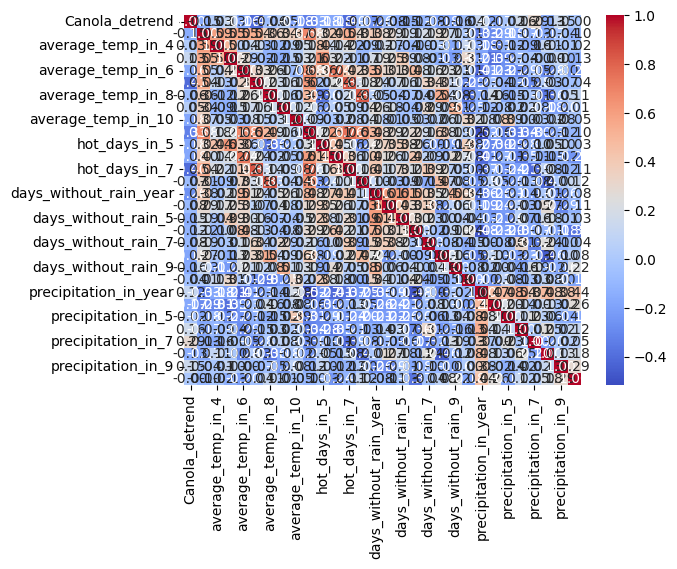

                  Variable           VIF
0                    const  5.933886e+05
1     average_temp_in_year  1.604223e+10
2        average_temp_in_4  2.888915e+09
3        average_temp_in_5  1.751746e+09
4        average_temp_in_6  1.088039e+09
5        average_temp_in_7  1.091204e+09
6        average_temp_in_8  1.119352e+09
7        average_temp_in_9  1.124988e+09
8       average_temp_in_10  1.218599e+09
9         hot_days_in_year  1.052882e+02
10           hot_days_in_5  6.612736e+00
11           hot_days_in_6  1.719243e+01
12           hot_days_in_7  3.663956e+01
13           hot_days_in_8  4.286344e+01
14  days_without_rain_year           inf
15     days_without_rain_4           inf
16     days_without_rain_5           inf
17     days_without_rain_6           inf
18     days_without_rain_7           inf
19     days_without_rain_8           inf
20     days_without_rain_9           inf
21    days_without_rain_10           inf
22   precipitation_in_year  1.501200e+14
23      precipit

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [23]:
#linear regression using all covariates 

y = canola_lr.iloc[:, 0] 
X = canola_lr.iloc[:, 1:] 

X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

# multicollianrity

#correlation matrix
correlation_matrix = canola_lr.corr()
print(correlation_matrix)

sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.show()

#VIF Test 
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

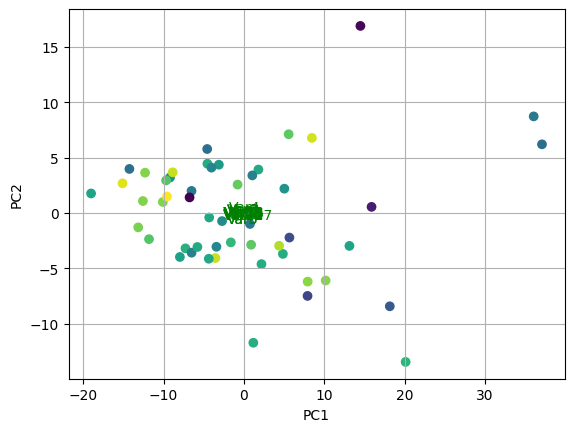

1.0000000000000002


In [24]:
# PCA to tackle multicollinearity

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = canola_lr.iloc[:, 1:] 
scaler.fit(X)

pca = PCA()
pca.fit(X, y)
X_pca_new = pca.transform(X)   

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]

    plt.scatter(xs ,ys, c = y) #without scaling
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

myplot(X_pca_new[:,0:2], pca.components_) 
plt.show()

# pca_model = sm.OLS(y, X_pca)
# pca_results = pca_model.fit()

# print(pca_results.summary())

print(sum(pca.explained_variance_ratio_))


In [25]:
X.columns

Index(['average_temp_in_year', 'average_temp_in_4', 'average_temp_in_5',
       'average_temp_in_6', 'average_temp_in_7', 'average_temp_in_8',
       'average_temp_in_9', 'average_temp_in_10', 'hot_days_in_year',
       'hot_days_in_5', 'hot_days_in_6', 'hot_days_in_7', 'hot_days_in_8',
       'days_without_rain_year', 'days_without_rain_4', 'days_without_rain_5',
       'days_without_rain_6', 'days_without_rain_7', 'days_without_rain_8',
       'days_without_rain_9', 'days_without_rain_10', 'precipitation_in_year',
       'precipitation_in_4', 'precipitation_in_5', 'precipitation_in_6',
       'precipitation_in_7', 'precipitation_in_8', 'precipitation_in_9',
       'precipitation_in_10'],
      dtype='object')

In [26]:
# get the most important features on the PCs with names and save them into a pandas df

model = PCA(n_components=3).fit(X)
X_pc = model.transform(X)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = ['average_temp_in_year', 'average_temp_in_4', 'average_temp_in_5',
       'average_temp_in_6', 'average_temp_in_7', 'average_temp_in_8',
       'average_temp_in_9', 'average_temp_in_10', 'hot_days_in_year',
       'hot_days_in_5', 'hot_days_in_6', 'hot_days_in_7', 'hot_days_in_8',
       'days_without_rain_year', 'days_without_rain_4', 'days_without_rain_5',
       'days_without_rain_6', 'days_without_rain_7', 'days_without_rain_8',
       'days_without_rain_9', 'days_without_rain_10', 'precipitation_in_year',
       'precipitation_in_4', 'precipitation_in_5', 'precipitation_in_6',
       'precipitation_in_7', 'precipitation_in_8', 'precipitation_in_9',
       'precipitation_in_10']

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df_pca = pd.DataFrame(dic.items())

print(df_pca)

     0                       1
0  PC0        hot_days_in_year
1  PC1           hot_days_in_8
2  PC2  days_without_rain_year


In [27]:
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA

pls = PLSRegression(n_components=2)
pls_reg = pls.fit(X, y)
print(pls_reg)

PLSRegression()


In [28]:
# linear regression using just average temp in month 

y = canola_lr.iloc[:, 0] 
X = canola_lr.iloc[:, 2:9] 

X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Canola_detrend   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     1.943
Date:                Sun, 28 Jan 2024   Prob (F-statistic):             0.0852
Time:                        16:24:14   Log-Likelihood:                -142.60
No. Observations:                  52   AIC:                             301.2
Df Residuals:                      44   BIC:                             316.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                217.2270    190

In [29]:
# linear regression using all covs log-transformed; no difference 

y = canola_lr.iloc[:, 0] 
X = canola_lr.iloc[:, 2:9] 

X =  np.log1p(X)
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Canola_detrend   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     1.939
Date:                Sun, 28 Jan 2024   Prob (F-statistic):             0.0860
Time:                        16:24:14   Log-Likelihood:                -142.61
No. Observations:                  52   AIC:                             301.2
Df Residuals:                      44   BIC:                             316.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1238.0345   1083

In [30]:
# linear regression using just hot days in month 

y = canola_lr.iloc[:, 0] 
X = canola_lr.iloc[:, 10:14] 

X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Canola_detrend   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     2.471
Date:                Sun, 28 Jan 2024   Prob (F-statistic):             0.0573
Time:                        16:24:14   Log-Likelihood:                -144.64
No. Observations:                  52   AIC:                             299.3
Df Residuals:                      47   BIC:                             309.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.2320      1.134      1.968

In [31]:
# linear regression using just days without rain in month 

y = canola_lr.iloc[:, 0] 
X = canola_lr.iloc[:, 15:22] 

X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Canola_detrend   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                 -0.057
Method:                 Least Squares   F-statistic:                    0.6049
Date:                Sun, 28 Jan 2024   Prob (F-statistic):              0.749
Time:                        16:24:14   Log-Likelihood:                -147.22
No. Observations:                  52   AIC:                             310.4
Df Residuals:                      44   BIC:                             326.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.1471 

In [32]:
# linear regression using just percipitation in month 

y = canola_lr.iloc[:, 0] 
X = canola_lr.iloc[:, 23:] 

X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Canola_detrend   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     1.478
Date:                Sun, 28 Jan 2024   Prob (F-statistic):              0.200
Time:                        16:24:14   Log-Likelihood:                -144.11
No. Observations:                  52   AIC:                             304.2
Df Residuals:                      44   BIC:                             319.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -3.0864    

In [33]:
# linear regression using yearly variables

y = canola_lr.iloc[:, 0] 
X = canola_lr.loc[:, ['average_temp_in_year', 'precipitation_in_year','days_without_rain_year','hot_days_in_year']] 

X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Canola_detrend   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     1.926
Date:                Sun, 28 Jan 2024   Prob (F-statistic):              0.122
Time:                        16:24:15   Log-Likelihood:                -145.66
No. Observations:                  52   AIC:                             301.3
Df Residuals:                      47   BIC:                             311.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -211

In [34]:
# linear regression using variables in may

y = canola_lr.iloc[:, 0] 
X = canola_lr.loc[:, ['average_temp_in_5', 'precipitation_in_5','days_without_rain_5','hot_days_in_5']]

X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Canola_detrend   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     2.096
Date:                Sun, 28 Jan 2024   Prob (F-statistic):             0.0963
Time:                        16:24:15   Log-Likelihood:                -145.34
No. Observations:                  52   AIC:                             300.7
Df Residuals:                      47   BIC:                             310.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -251.2755    

### Simple linear Regression model 

                            OLS Regression Results                            
Dep. Variable:         Canola_detrend   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     9.425
Date:                Sun, 28 Jan 2024   Prob (F-statistic):            0.00346
Time:                        16:24:15   Log-Likelihood:                -145.11
No. Observations:                  52   AIC:                             294.2
Df Residuals:                      50   BIC:                             298.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.8868      0.830      2.274

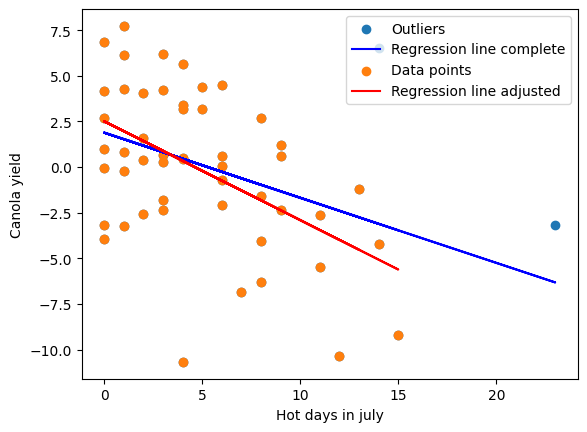

In [35]:
# Hot days in july

y = canola_lr.iloc[:, 0] 
X_1 = canola_lr[["hot_days_in_7"]]

X_1 = sm.add_constant(X_1)

model = sm.OLS(y, X_1)
results_one = model.fit()

print(results_one.summary())

plt.scatter(canola_lr[["hot_days_in_7"]], canola_lr[["Canola_detrend"]], label='Outliers')

# Plot the regression line
plt.plot(canola_lr[["hot_days_in_7"]], results_one.predict(), color='blue', label='Regression line complete')

# Add labels and a legend
plt.xlabel('Hot days in july')
plt.ylabel('Canola yield')
plt.legend()

# Show the plot
#plt.show()

# check for outliners:
df_july = canola_lr.iloc[:, [0,12]]

#print(df_july)

#the utliers are 2017 and 2021

years_to_remove = ['2017', '2021']

# Remove specific years from the DataFrame
df_july = df_july.drop(years_to_remove, axis=0)

# Display the resulting DataFrame
#print(df_july)

# lr with removed outliers 

y = df_july.iloc[:, 0] 
X_mod = df_july.iloc[:,1]

X_mod = sm.add_constant(X_mod)

model = sm.OLS(y, X_mod)
results_one = model.fit()

print(results_one.summary())

plt.scatter(df_july[["hot_days_in_7"]], df_july[["Canola_detrend"]], label='Data points')

# Plot the regression line
plt.plot(df_july[["hot_days_in_7"]], results_one.predict(), color='red', label='Regression line adjusted')

# Add labels and a legend
plt.xlabel('Hot days in july')
plt.ylabel('Canola yield')
plt.legend()




                            OLS Regression Results                            
Dep. Variable:         Canola_detrend   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     5.994
Date:                Sun, 28 Jan 2024   Prob (F-statistic):             0.0179
Time:                        16:24:17   Log-Likelihood:                -146.66
No. Observations:                  52   AIC:                             297.3
Df Residuals:                      50   BIC:                             301.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.2762      1.093  

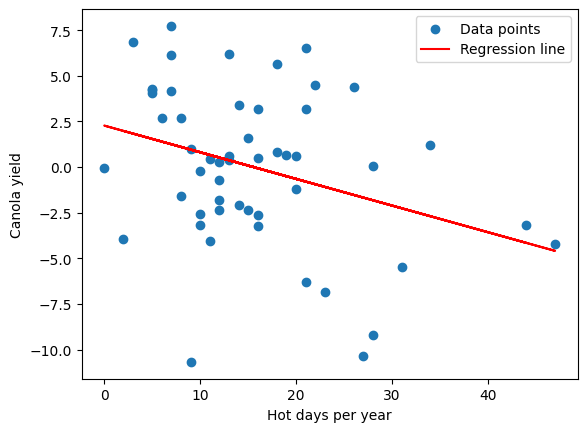

In [36]:
# Hot days in year

y = canola_lr.iloc[:, 0] 
X_1 = canola_lr[["hot_days_in_year"]]

X_1 = sm.add_constant(X_1)

model = sm.OLS(y, X_1)
results_one = model.fit()

print(results_one.summary())

plt.scatter(canola_lr[["hot_days_in_year"]], canola_lr[["Canola_detrend"]], label='Data points')

# Plot the regression line
plt.plot(canola_lr[["hot_days_in_year"]], results_one.predict(), color='red', label='Regression line')

# Add labels and a legend
plt.xlabel('Hot days per year')
plt.ylabel('Canola yield')
plt.legend()

# Show the plot
plt.show()

                            OLS Regression Results                            
Dep. Variable:         Canola_detrend   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.1850
Date:                Sun, 28 Jan 2024   Prob (F-statistic):              0.669
Time:                        16:24:19   Log-Likelihood:                -149.51
No. Observations:                  52   AIC:                             303.0
Df Residuals:                      50   BIC:                             306.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                45.9086    106.74

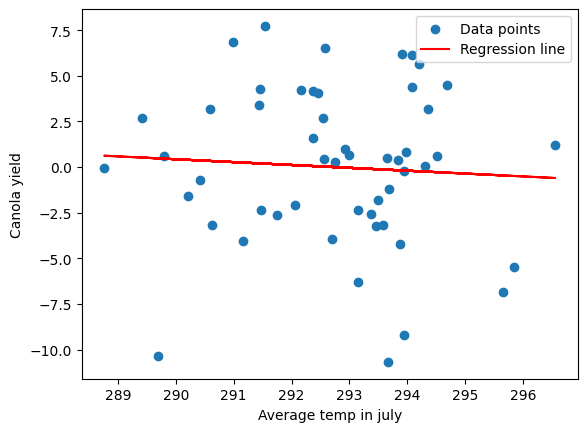

In [37]:
# average temp in july 

y = canola_lr.iloc[:, 0] 
X_1 = canola_lr[["average_temp_in_8"]]

X_1 = sm.add_constant(X_1)

model = sm.OLS(y, X_1)
results_one = model.fit()

print(results_one.summary())

plt.scatter(canola_lr[["average_temp_in_8"]], canola_lr[["Canola_detrend"]], label='Data points')

# Plot the regression line
plt.plot(canola_lr[["average_temp_in_8"]], results_one.predict(), color='red', label='Regression line')

# Add labels and a legend
plt.xlabel('Average temp in july')
plt.ylabel('Canola yield')
plt.legend()

# Show the plot
plt.show()

# Ordinal scale? 

                            OLS Regression Results                            
Dep. Variable:         Canola_detrend   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.086
Date:                Sun, 28 Jan 2024   Prob (F-statistic):              0.302
Time:                        16:24:22   Log-Likelihood:                -149.05
No. Observations:                  52   AIC:                             302.1
Df Residuals:                      50   BIC:                             306.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  196.6081 

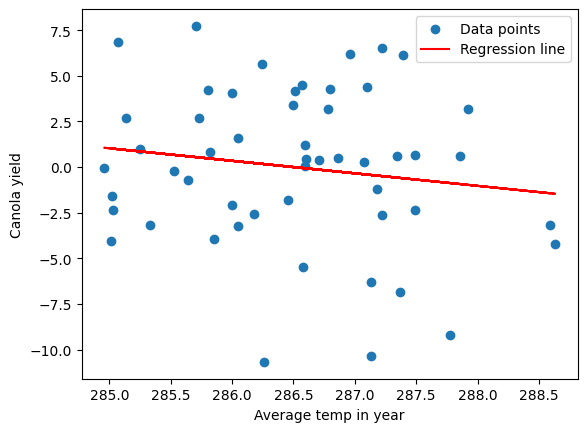

In [38]:
# average temp in year

y = canola_lr.iloc[:, 0] 
X_1 = canola_lr[["average_temp_in_year"]]

X_1 = sm.add_constant(X_1)

model = sm.OLS(y, X_1)
results_one = model.fit()
residuals = results_one.resid
fitted_values = results_one.fittedvalues

print(results_one.summary())

plt.scatter(canola_lr[["average_temp_in_year"]], canola_lr[["Canola_detrend"]], label='Data points')

# Plot the regression line
plt.plot(canola_lr[["average_temp_in_year"]], results_one.predict(), color='red', label='Regression line')

# Add labels and a legend
plt.xlabel('Average temp in year')
plt.ylabel('Canola yield')
plt.legend()

# Show the plot
plt.show()

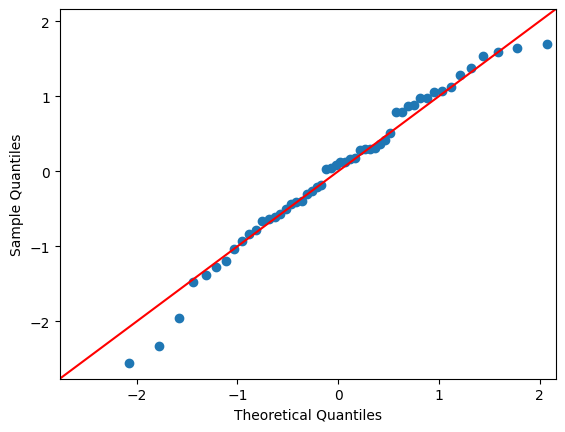

In [39]:
sm.qqplot(residuals, line='45', fit=True)
plt.show()

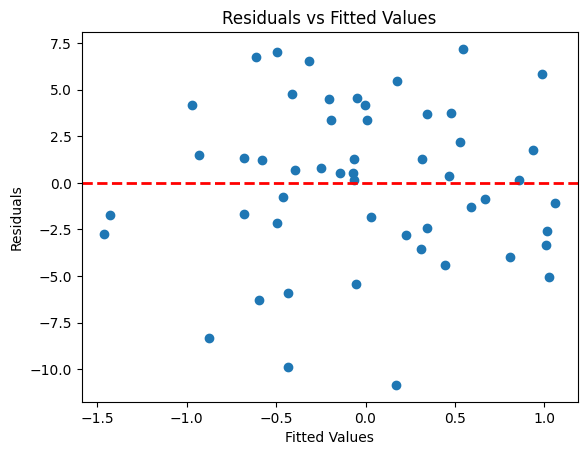

In [40]:
plt.scatter(fitted_values, residuals)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

                            OLS Regression Results                            
Dep. Variable:         Canola_detrend   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     4.713
Date:                Sun, 28 Jan 2024   Prob (F-statistic):             0.0347
Time:                        16:24:28   Log-Likelihood:                -147.26
No. Observations:                  52   AIC:                             298.5
Df Residuals:                      50   BIC:                             302.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.3664      1

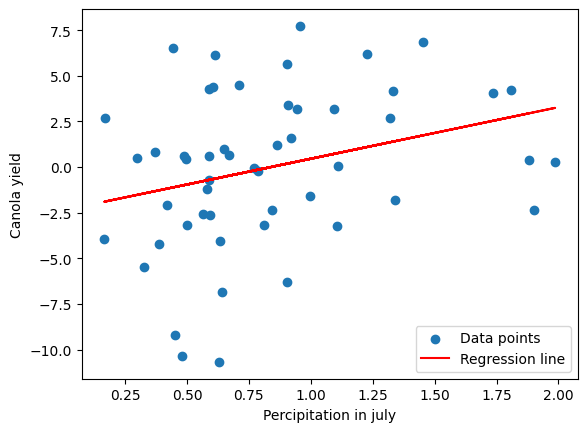

In [41]:
# percipitation in july

y = canola_lr.iloc[:, 0] 
X_1 = canola_lr[["precipitation_in_7"]]

X_1 = sm.add_constant(X_1)

model = sm.OLS(y, X_1)
results_one = model.fit()

print(results_one.summary())

plt.scatter(canola_lr[["precipitation_in_7"]], canola_lr[["Canola_detrend"]], label='Data points')

# Plot the regression line
plt.plot(canola_lr[["precipitation_in_7"]], results_one.predict(), color='red', label='Regression line')

# Add labels and a legend
plt.xlabel('Percipitation in july')
plt.ylabel('Canola yield')
plt.legend()

# Show the plot
plt.show()

In [42]:
len(canola_lr)

52

                            OLS Regression Results                            
Dep. Variable:         Canola_detrend   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.110
Date:                Sun, 28 Jan 2024   Prob (F-statistic):              0.297
Time:                        16:24:30   Log-Likelihood:                -149.03
No. Observations:                  52   AIC:                             302.1
Df Residuals:                      50   BIC:                             306.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.5645    

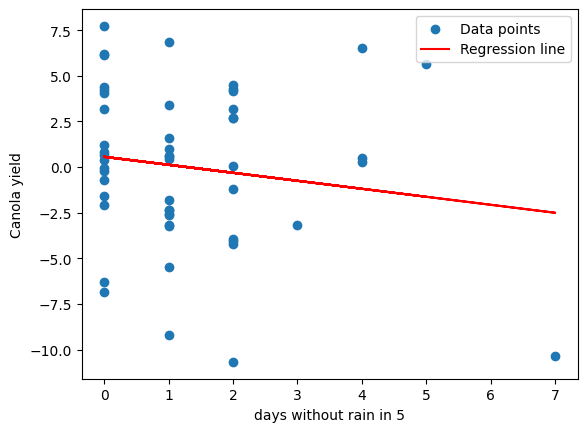

In [43]:
# days without rain 

y = canola_lr.iloc[:, 0] 
X_1 = canola_lr[["days_without_rain_5"]]

X_1 = sm.add_constant(X_1)

model = sm.OLS(y, X_1)
results_one = model.fit()

print(results_one.summary())

plt.scatter(canola_lr[["days_without_rain_5"]], canola_lr[["Canola_detrend"]], label='Data points')

# Plot the regression line
plt.plot(canola_lr[["days_without_rain_5"]], results_one.predict(), color='red', label='Regression line')

# Add labels and a legend
plt.xlabel('days without rain in 5')
plt.ylabel('Canola yield')
plt.legend()

# Show the plot
plt.show()

#non are significant 

### ARIMA 

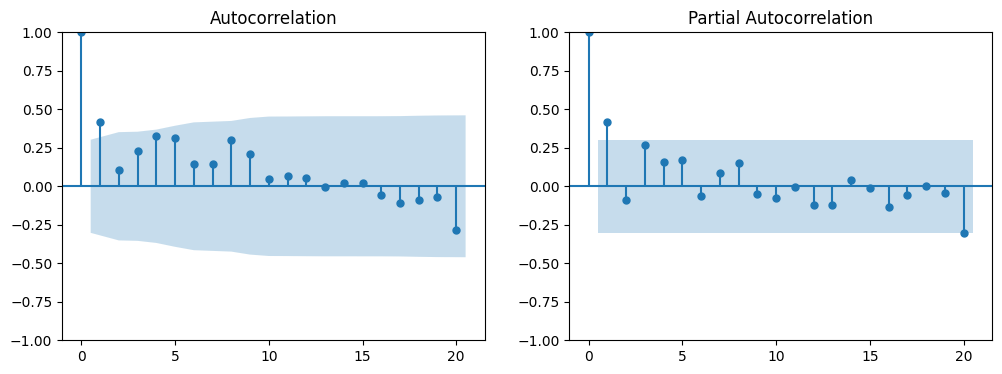

In [44]:
# ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(training_set['Canola'], lags=20, ax=ax1) # p = 1
plot_pacf(training_set['Canola'], lags=20, ax=ax2) # q = 1

plt.show()


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Canola   No. Observations:                   42
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -123.138
Date:                Sun, 28 Jan 2024   AIC                            250.275
Time:                        16:24:34   BIC                            253.702
Sample:                    01-01-1971   HQIC                           251.523
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8045      0.106     -7.591      0.000      -1.012      -0.597
sigma2        23.1829      5.550      4.177      0.000      12.305      34.060
Ljung-Box (L1) (Q):                   0.61   Jarque-

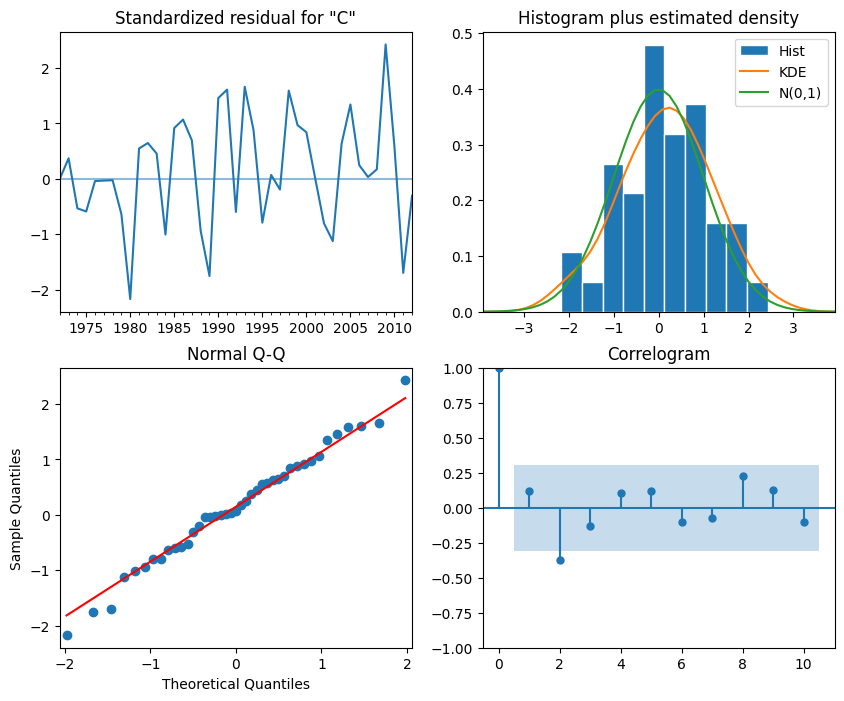

In [45]:
#fit model 

p, d, q = (0, 1, 1)
model = ARIMA(training_set['Canola'], order=(p, d, q), freq = "AS-JAN")
results = model.fit()

# Print model summary
print(results.summary())

# Plot diagnostics
results.plot_diagnostics(figsize=(10, 8))
plt.show()

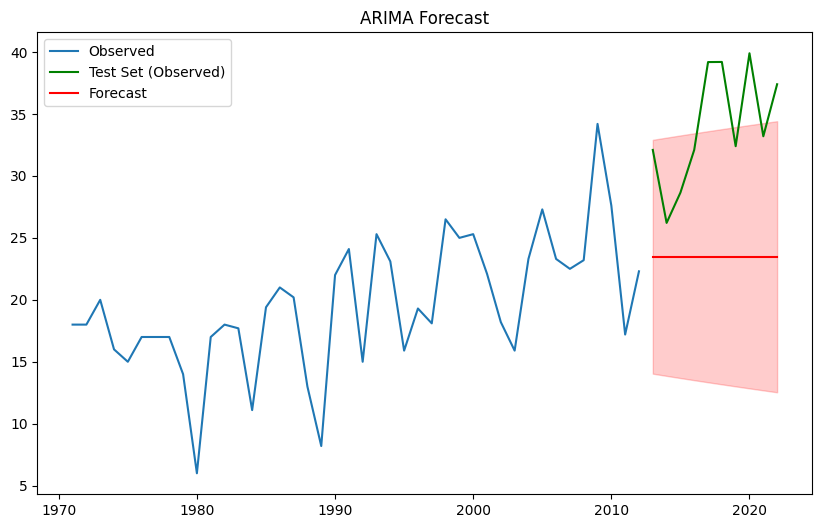

In [46]:
#forecastingt 

forecast_steps = 10 
forecast = results.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

forecast_start_date = training_set.index[-1] + pd.DateOffset(years=1)
forecast_end_date = forecast.predicted_mean.index[-1]
full_index = pd.date_range(start=training_set.index[0], end=forecast_end_date, freq='AS-JAN')
forecast.predicted_mean = forecast.predicted_mean.reindex(full_index, fill_value=None)

plt.figure(figsize=(10, 6))
plt.plot(training_set['Canola'], label='Observed')
plt.plot(test_set.index, test_set['Canola'], label='Test Set (Observed)', color='green')
plt.plot(forecast.predicted_mean, color='red', label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.2)
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

### Exponential Smoothing 

In [47]:
alpha_star = None
best_mse = None
dat = canola_dist1.iloc[:, :].values.astype('float32')
mean_results_for_all_possible_alpha_values = np.zeros(9)
for alpha in range(0, 9):
    pt = np.mean(dat[:, 0][0:5])
    mean_for_alpha = np.zeros(len(dat))
    mean_for_alpha[0] = np.power(dat[0][0] - pt, 2)
    for i in range(1, len(dat)):
        pt = pt + ((alpha + 1) * 0.1) * (dat[i - 1][0] - pt)
        mean_for_alpha[i] = np.power(dat[i][0] - pt, 2)
    mean_results_for_all_possible_alpha_values[alpha] = np.mean(mean_for_alpha)
alpha_star = (np.argmin(mean_results_for_all_possible_alpha_values) + 1) * 0.1
best_mse = np.min(mean_results_for_all_possible_alpha_values)
print("Best MSE = %s" % best_mse)
print("Optimal alpha = %s" % alpha_star)

Best MSE = 0.0
Optimal alpha = 0.1


In [48]:
model3 = SimpleExpSmoothing(training_set['Canola'])
model3_fit = model3.fit(smoothing_level=0.1,optimized=False)
model3_fit.params
y_hat_ses = test_set.copy()
y_hat_ses['ses_forecast'] = model3_fit.forecast(len(test_set))

print(y_hat_ses['ses_forecast'])

Year
2013-01-01    22.554573
2014-01-01    22.554573
2015-01-01    22.554573
2016-01-01    22.554573
2017-01-01    22.554573
2018-01-01    22.554573
2019-01-01    22.554573
2020-01-01    22.554573
2021-01-01    22.554573
2022-01-01    22.554573
Name: ses_forecast, dtype: float64


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


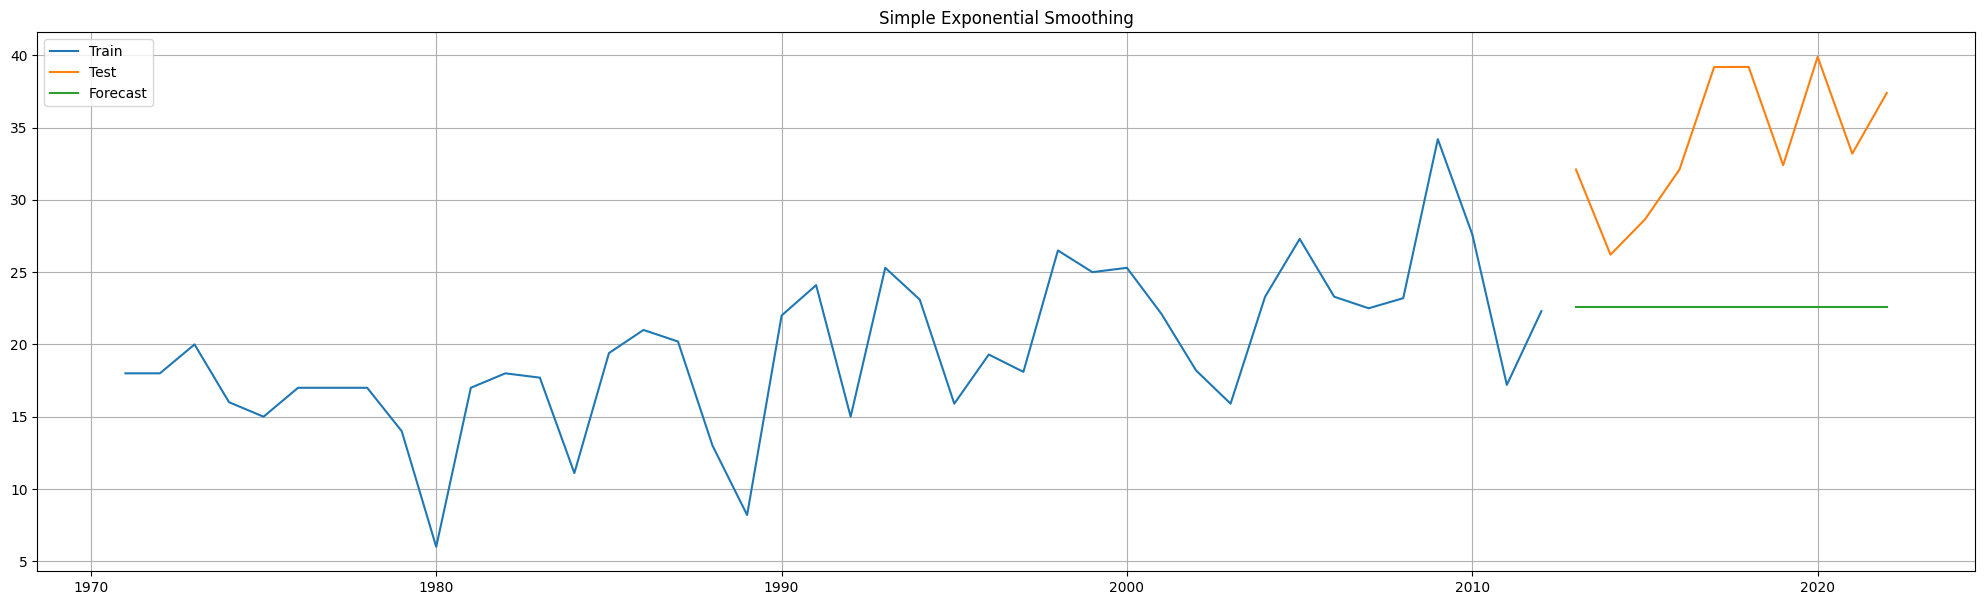

In [49]:
plt.figure(figsize=(25,7))
plt.grid()
plt.plot(training_set['Canola'], label='Train')
plt.plot(test_set['Canola'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing')
plt.show()

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame containing the variables
# 'Canola_detrend', 'average_temp_in_year', 'precipitation_in_year', etc.

# Extract relevant features and target variable
features = canola_lr.drop('Canola_detrend', axis=1).values
target = canola_lr['Canola_detrend'].values.reshape(-1, 1)

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.Tensor(X_train).unsqueeze(2)  # Add an extra dimension for the input sequence
y_train_tensor = torch.Tensor(y_train)

X_test_tensor = torch.Tensor(X_test).unsqueeze(2)
y_test_tensor = torch.Tensor(y_test)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train_tensor.shape[2]
hidden_size = 50
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 30 # still way too little

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}') # print loss every 5th epoch

# Evaluation on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)

print(f'Test Loss: {test_loss.item():.4f}')


Epoch [5/30], Loss: 18.1178
Epoch [10/30], Loss: 18.0445
Epoch [15/30], Loss: 17.9844
Epoch [20/30], Loss: 17.9724
Epoch [25/30], Loss: 17.9413
Epoch [30/30], Loss: 17.9112
Test Loss: 20.9677


In [51]:
import requests

url = "https://services9.arcgis.com/WJsMXAAF3vSdDYis/arcgis/rest/services/SaskAdmin_2016_rural_municipality/FeatureServer/0"
response = requests.get(url, params={"param1": "value1", "param2": "value2"}, headers={"Authorization": "Bearer YOUR_TOKEN"})

# Check the status code
# if response.status_code == 200:
#     # The request was successful
#     data = response.json()
# else:
#     # Handle the error
#     print(f"Error: {response.status_code}")

ConnectTimeout: HTTPSConnectionPool(host='services9.arcgis.com', port=443): Max retries exceeded with url: /WJsMXAAF3vSdDYis/arcgis/rest/services/SaskAdmin_2016_rural_municipality/FeatureServer/0?param1=value1&param2=value2 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001610F1D5AD0>, 'Connection to services9.arcgis.com timed out. (connect timeout=None)'))